<a href="https://colab.research.google.com/github/Mirwais-Farahi/LTA-DataQualityCheck/blob/main/LTADataCollection_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
from google.colab import data_table

data_table.enable_dataframe_formatter()
!pip install --upgrade git+https://github.com/mirwais-farahi/KoboDataExtractor.git

  Cloning https://github.com/mirwais-farahi/KoboDataExtractor.git to /tmp/pip-req-build-h85qffcr
  Running command git clone --filter=blob:none --quiet https://github.com/mirwais-farahi/KoboDataExtractor.git /tmp/pip-req-build-h85qffcr
  Resolved https://github.com/mirwais-farahi/KoboDataExtractor.git to commit 523e5c2851b851f9eae313a9171b6d2d690fc82f
  Preparing metadata (setup.py) ... done


In [68]:
from KoboDataExtractor.KoboDataFetcher import KoboDataFetcher

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
# Use the module as intended
'''
PDM Form ID: aMSpJ7vpGUdDYfBakatSff
Outcome Form ID: aHDFcWo745yEdv6bJvdJQt
Baseline Form ID: aDf3pqeP6u9vuaoxjiaEAQ
'''
base_url = "https://eu.kobotoolbox.org/api/v2/assets/{asset_uid}/data/"
api_token = "0e7a75b50290d146396d6a3efef6d6de287683c6"
asset_uid = input("Enter your KoboToolbox Form ID: ").strip()
limit = int(input("Enter limit for number of records: ").strip() or 100000)

# Create instance of KoboDataFetcher
kobo_fetcher = KoboDataFetcher(base_url, api_token, asset_uid, limit)
df = kobo_fetcher.fetch_data()

if df is not None:
    print("Data fetched successfully:")
else:
    print("Failed to fetch data.")

Enter your KoboToolbox Form ID: aHDFcWo745yEdv6bJvdJQt
Enter limit for number of records: 100000
Data fetched successfully:


In [70]:
df.head()

,_id,start,end,today,consent,respondent_group,province,district,village,surveyor_name,sur_num,surveyor_org,respondent_name,respondent_father,nid,phone,alternative_phone,sex,marital_status,age,spouse_alternative,special_char,residence,hh_member,head_hh,other_information,hh_type,name_original,nid_original,hh_type_reserve_reason,project_code,assistance,cfw_receipt,cfw_activity,cfw_involved,cfw_selection,cfw_consultation,cfw_cash,cfw_cash_expect,cfw_days,cfw_hours,cash_collect_place,cfw_market,cfw_help,item_purchased,amount_food,amount_debt,cfw_importance,cfw_benefits,cfw_evaluation,hh_benefited,cfw_intervention_function,cfw_intervention_function_reason,cfw_selection_type,cfw_tension,cfw_tension_type,cfw_idea,other_suggestions,cereals,pulses,milk,meat,veg,fruit,oil,sugar,fcs_score,fcs_analysis,lcs_1,lcs_2,lcs_3,lcs_4,lcs_5,lcs_6,lcs_7,lcs_8,lcs_9,lcs_10,lcs_11,larger_benefits,specific_expectation,other_information_001,nid_photo,thankyou,instanceID,deprecatedID,uuid,__version__,_xform_id_string,_uuid,_attachments,_status,_geolocation,_submission_time,_tags,_notes,_validation_status,_submitted_by,uct_receipt,uct_selection,uct_cash,uct_cash_expect,uct_cash_collect_place,uct_market,uct_help,uct_item_purchased,uct_amount_food,uct_amount_debt,uct_cashlast,uct_other_suggestions,spouse_alternative_name,head_hh_no,hh_head_sex,hh_head_nid,hh_head_age,hh_head_marital,hh_head_dis,amount_health,amount_school,uct_amount_health,mung_receipt,Did_you_cultivate_the_FAO_give,mungfao_verity_irrigated,mungfao_land_cultivated_irrigated,mungfao_date_irrigated,mungfao_seed_rate_irrigated,mungfao_yield_irrigated,mungfao_yield_last,mungfao_straw_irrigated,Did_you_cultivate_local_mung_b,mung_sold,mungfao_preserved_irrigated,mung_timeliness,mungsow_timeliness,mung_satisfiction,mung_disease_pest,mung_disease_pest_type,mung_lost_percent,mung_constraints,mung_training_received,mung_training_learn,mung_training_apply,mung_training_satisfiction,cash_collect_place_other,amount_agriculture,cfw_cash_expect_other,munglocal_verity_irrigated,munglocal_land_cultivated_irrigated,munglocal_date_irrigated,munglocal_seed_rate_irrigated,munglocal_yield_irrigated,munglocal_straw_irrigated,munglocal_yield_last,mung_sold_money,mung_satisfiction_other,hg_receipt,veg_cult,veg_cultivated,veg_amount,veg_satisfiction,tomato_yield,egg_plant_yield,okra_yield,squash_yield,cabbage_yield,onion_yield,red_radish_yield,corriander_yield,harvest_satisfiction,veg_consumption,veg_perfer,seed_collected,plan_veg_cultivation,veg_source,veg_constraints,time_hg,ppl_engaged,veg_training_received,veg_training_learn,veg_training_apply,veg_training_satisfiction,veg_satisfiction_other,harvest_satisfiction_other,seed_not_collected,no_cultivation,reason_nocultivation,cfw_activity_other,cfw_benefits_other,no_cultivation_result,veg_constraints_other,uct_amount_agriculture,livstock_receipt,feed_amount,livestock_training,feed_sufficient_animals,feed_sufficient_time,feed_effect,gain_weight,animal_production,use_production,water_source,dairy_income,use_production_other,uct_amount_school,uct_cash_collect_place_other,sesame_receipt,uct_help_other,uct_item_purchased_other,uct_amount_other,cfw_help_other,amount_livestock,idp_province,amount_ceremony,no_cultivation_other,veg_training_no_apply_reason,cfw_involved_other,veg_training_satisfiction_no,mung_training_no_apply_reason,item_purchased_other,amount_other,hh_type_reserve_reason_other,uct_amount_livestock,uct_amount_ceremony,mungfao_verity_irrigated_other,Did_you_cultivate_the_FAO_give_001,sesamefao_verity_rainfed,sesamefao_land_cultivated_rainfed,sesamefao_date_rainfed,sesamefao_seed_rate_rainfed,sesamefao_yield_rainfed,sesamefao_yield_last,sesamefao_straw_rainfed,Did_you_cultivate_local_mung_s,sesame_sold,sesamefao_preserved_rainfed,sesame_timeliness,sesamesow_timeliness,sesame_satisfiction,sesame_disease_pest,sesame_constraints,sesame_training_received,sesame_training_learn,sesame_training_apply,sesame_training_satisfiction,sesamelocal_verity_rainfed,sesameloca

In [71]:
row_count = df.shape[0]
print("Number of rows in the DataFrame:", row_count)

Number of rows in the DataFrame: 34969


In [ ]:
# Set display options
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns

In [73]:
df[["project_code", "assistance"]].drop_duplicates()

,project_code,assistance
0,122_den,cfw
9,122_den,uct
31,121_ita,mung
37,122_den,mung
71,122_den,vegetable
95,121_ita,cfw
107,121_ita,uct
167,121_ita,livestock
466,121_ita,sesame
2234,123_chg,livestock


In [74]:
# Initialize lists to hold project codes and intervention types
project_codes_to_count = []
intervention_types_to_count = []

# Function to get user input and add to the lists
def add_to_list():
    print("Enter project codes. Type 'done' when finished:")
    while True:
        project_code = input("Enter a project code (or 'done' to finish): ")
        if project_code.lower() == 'done':
            break
        project_codes_to_count.append(project_code)
        print(f"Added project code '{project_code}' to the list.")

    print("Enter intervention types. Type 'done' when finished:")
    while True:
        intervention_type = input("Enter an intervention type (or 'done' to finish): ")
        if intervention_type.lower() == 'done':
            break
        intervention_types_to_count.append(intervention_type)
        print(f"Added intervention type '{intervention_type}' to the list.")

# Get user input
add_to_list()

# Filter the DataFrame by the specified project codes and intervention types
filtered_df = df[(df['project_code'].isin(project_codes_to_count)) & (df['assistance'].isin(intervention_types_to_count))]

# Group by Province and District and count the number of surveys in each district
result = filtered_df.groupby(['province', 'district']).size().reset_index(name='Total Surveys in District')

# Display the result
result

Enter project codes. Type 'done' when finished:
Enter a project code (or 'done' to finish): osro_afg_130_cha
Added project code 'osro_afg_130_cha' to the list.
Enter a project code (or 'done' to finish): done
Enter intervention types. Type 'done' when finished:
Enter an intervention type (or 'done' to finish): cfw
Added intervention type 'cfw' to the list.
Enter an intervention type (or 'done' to finish): done


,province,district,Total Surveys in District
0,Badakhshan,Khwahan,32
1,Badakhshan,Raghestan,31
2,Badakhshan,Shuhada,29
3,Badakhshan,Teshakan,24
4,Badakhshan,Yaftal-e-Sufla,24
5,Badakhshan,tagab_b,31
6,Badghis,Bala Murghab (Morghab),31
7,Badghis,Jawand,31
8,Badghis,Qadis,31
9,Nuristan,Norgram,33


In [77]:
filtered_df = filtered_df.dropna(axis=1, how='all')
filtered_df.head()

,_id,start,end,today,consent,respondent_group,province,district,village,surveyor_name,sur_num,surveyor_org,respondent_name,respondent_father,nid,phone,alternative_phone,sex,marital_status,age,spouse_alternative,special_char,residence,hh_member,head_hh,other_information,hh_type,name_original,nid_original,hh_type_reserve_reason,project_code,assistance,cfw_receipt,cfw_activity,cfw_involved,cfw_selection,cfw_consultation,cfw_cash,cfw_cash_expect,cfw_days,cfw_hours,cash_collect_place,cfw_market,cfw_help,item_purchased,amount_food,amount_debt,cfw_importance,cfw_benefits,cfw_evaluation,hh_benefited,cfw_intervention_function,cfw_intervention_function_reason,cfw_selection_type,cfw_tension,cfw_tension_type,cfw_idea,other_suggestions,cereals,pulses,milk,meat,veg,fruit,oil,sugar,fcs_score,fcs_analysis,lcs_1,lcs_2,lcs_3,lcs_4,lcs_5,lcs_6,lcs_7,lcs_8,lcs_9,lcs_10,lcs_11,larger_benefits,specific_expectation,instanceID,uuid,__version__,_xform_id_string,_uuid,_attachments,_status,_geolocation,_submission_time,_tags,_notes,_validation_status,_submitted_by,spouse_alternative_name,head_hh_no,hh_head_sex,hh_head_nid,hh_head_age,hh_head_marital,hh_head_dis,amount_health,amount_school,cash_collect_place_other,amount_agriculture,cfw_activity_other,cfw_benefits_other,amount_livestock,cfw_involved_other,hhs_1,hhs_2,hhs_3,hhs_4,hhs_5,hhs_6,satisfiction_1,cheap_food,pts_cheap_food,borrow,pts_borrow,reduce_portion,pts_reduce_portion,prioritize_child_meals,pts_prioritize_child_meals,skip_meals,pts_skip_meals,pts_total_rcsi,ipc_phase_rcsi,nid_photo,thankyou,other_information_001,satisfiction_2,satisfiction_3,satisfiction_4,satisfiction_6,satisfiction_7,satisfiction_8,satisfiction_9,satisfiction_10,device_id,deviceid,satisfiction_5
23279,549882916,2024-04-07T08:18:50.037+04:30,2024-04-07T08:31:43.839+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Deh Khala,Suhrab,700434038,aacs,Shah Mohammad,Faiz Mohammad,34100887,708582052,700000000,male,married,40,Ansar,no_dis,per_res,8,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,canal_rehabilitation,ip,ip,yes,6920,yes,20,8.0,ip_office,district_market same_location,access_food debt_prevent,food debt,5000.0,1920.0,very_useful,area_increased more_water reduce_distance,postive,60,yes,NaN,نیاز به آب زراعتی,no,NaN,هنوز هم بعضی ساحات نیاز به بازسازی کانال داریم,دو باره ایجاد شدن این شغل,7,2,3,0,0,2,4,2,37,Borderline,yes,no_didntfaceshortage,no_didntfaceshortage,yes,no_didntfaceshortage,no_didntfaceshortage,no_didntfaceshortage,no_didntfaceshortage,no_didntfaceshortage,no_didntfaceshortage,n_a,جلوگیری از گرفتن قرض نمود,دوباره شروع شدن این پروژه,uuid:a3e727e9-8500-42de-8f63-14a3cc7000dc,2fb8e2b70033434dbdd749599edddcbc,v3WTaE3vPTh4AUMJ9gzS2R,aHDFcWo745yEdv6bJvdJQt,a3e727e9-8500-42de-8f63-14a3cc7000dc,[{'download_url': 'https://eu.kobotoolbox.org/...,submitted_via_web,"[37.074647, 71.14854]",2024-04-07T22:11:34,[],[],{},fao4_2022,708582052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,no,NaN,no,NaN,no,frequency_1,0,frequency_1,0,frequency_2,0,frequency_1,0,frequency_2,0,0,Phase 1 - minimal,1712462397228.jpg,37.074647 71.14854 2095.1232559466134 4.613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,collect:FU0DbxGJoZoanafH,NaN,NaN
23280,549882948,2024-04-07T08:32:39.801+04:30,2024-04-07T08:41:39.426+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Deh Khala,Suhrab,700434038,aacs,Ansaruddin,Jalaluddin,25170925,708582052,700000000,male,married,23,Misbahuddin,no_dis,per_res,7,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,canal_rehabilitation,ip,ip,yes,6920,yes,20,8.0,ip_office,district_market same_location,access_food debt_reduce,food debt,2000.0,4920.0,very_useful,area_increased more_water,postive,55,yes,NaN,نیاز به آب زراعتی,no,NaN,افزایش پروژه ها,دوباره فعال شدن این نوع پروژه ها,7,1,3,0,0,1,4,2,33,Borderline,yes,no_didntfaceshortage,no_didntfaceshortage,yes,no_didntfaceshortage,no_didntfaceshortage,no_didntfaceshortage,no_didntfaceshortage,no_didntfaceshortage,n_a,n_a,جلوگیری از گرفتن قرض

Enter the column name to plot: cfw_cash


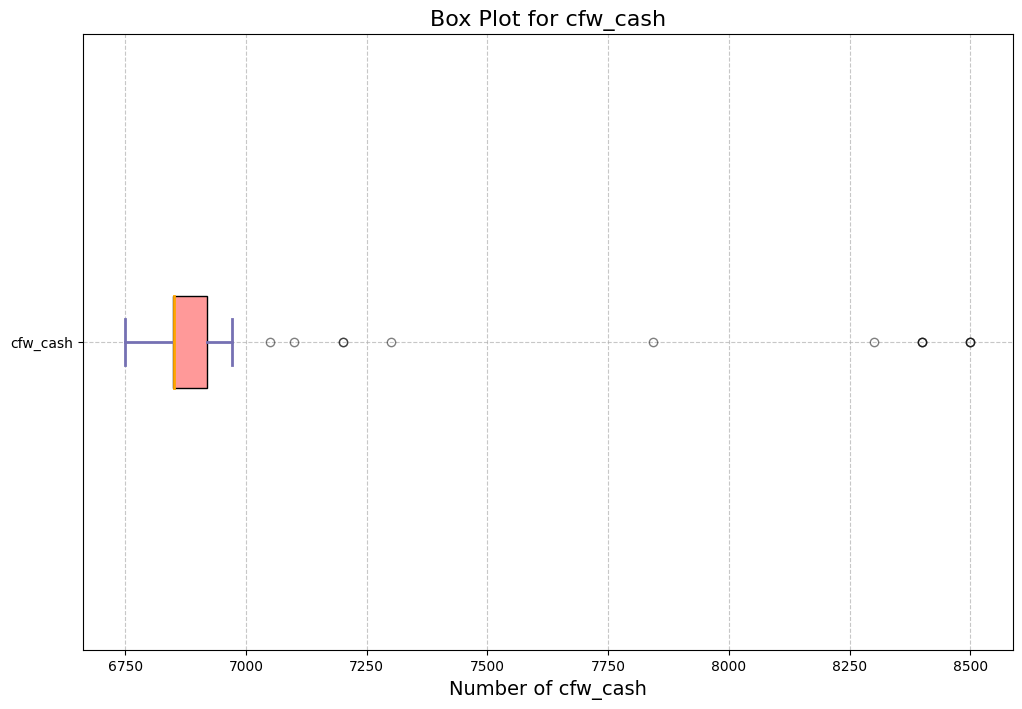

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Ask the user for the column name
column_name = input("Enter the column name to plot: ")

# Convert the column to numeric, forcing errors to NaN
filtered_df[column_name] = pd.to_numeric(filtered_df[column_name], errors='coerce')

# Drop rows with NaN values in the column
numeric_df = filtered_df.dropna(subset=[column_name])

# Define the column of interest
numeric_columns = [column_name]

# Draw the box plot
plt.figure(figsize=(12, 8))

# Create the box plot with improved readability
box = plt.boxplot(numeric_df[numeric_columns].values, vert=False, patch_artist=True, labels=numeric_columns)

# Customize the box plot
plt.title(f'Box Plot for {column_name}', fontsize=16)
plt.xlabel(f'Number of {column_name}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Set colors for the box plot elements
colors = ['#FF9999']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customize whiskers and medians
for whisker in box['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
for cap in box['caps']:
    cap.set(color='#7570b3', linewidth=2)
for median in box['medians']:
    median.set(color='orange', linewidth=2)
for flier in box['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

plt.show()

In [79]:
# Describe method
description = numeric_df[column_name].describe()
print(f"Descriptive statistics for '{column_name}':")
print(f"  - Number of entries: {description['count']}")
print(f"  - Average value: {description['mean']}")
print(f"  - Standard deviation: {description['std']}")
print(f"  - Minimum value: {description['min']}")
print(f"  - 25th percentile (25% of values are below this): {description['25%']}")
print(f"  - Median (50% of values are below this): {description['50%']}")
print(f"  - 75th percentile (75% of values are below this): {description['75%']}")
print(f"  - Maximum value: {description['max']}")

# Percentile calculation
percentiles = [0.9, 0.99]  # 90th and 99th percentiles
percentile_values = numeric_df[column_name].quantile(percentiles)
print(f"\n90th Percentiles for '{column_name}':")
print(f"  - 90th percentile (90% of values are below this): {percentile_values[0.9]}")
print(f"  - 99th percentile (99% of values are below this): {percentile_values[0.99]}")


Descriptive statistics for 'cfw_cash':
  - Number of entries: 389.0
  - Average value: 6896.910025706941
  - Standard deviation: 221.80802191262865
  - Minimum value: 6749.0
  - 25th percentile (25% of values are below this): 6849.0
  - Median (50% of values are below this): 6850.0
  - 75th percentile (75% of values are below this): 6920.0
  - Maximum value: 8500.0

90th Percentiles for 'cfw_cash':
  - 90th percentile (90% of values are below this): 6930.0
  - 99th percentile (99% of values are below this): 8400.0


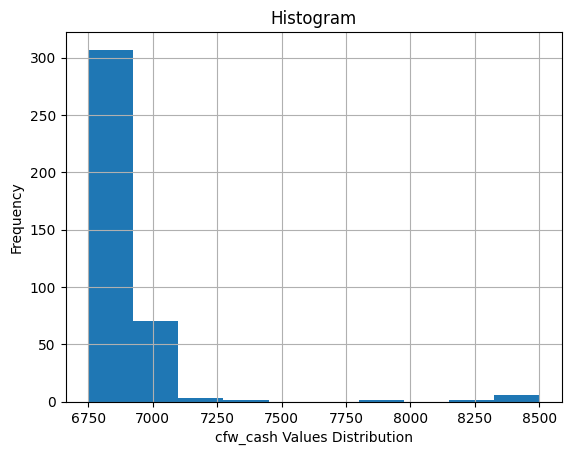

In [80]:
numeric_df[column_name].hist()
plt.xlabel(f'{column_name} Values Distribution')
plt.ylabel('Frequency')
plt.title(f'Histogram')
plt.show()

In [81]:
# Calculate the IQR for outlier detection
Q1 = filtered_df[numeric_columns[0]].quantile(0.25)
Q3 = filtered_df[numeric_columns[0]].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers_df = filtered_df[(filtered_df[numeric_columns[0]] < lower_bound) | (filtered_df[numeric_columns[0]] > upper_bound)]

print(f'Outliers Len: {len(outliers_df)}')

Outliers Len: 13


In [83]:
# Get the index of the specific column
col_index = outliers_df.columns.get_loc(column_name)

# Select columns from 0 to the specific column
selected_columns_outliers_df = outliers_df.iloc[:, :col_index + 1]

selected_columns_outliers_df

,_id,start,end,today,consent,respondent_group,province,district,village,surveyor_name,sur_num,surveyor_org,respondent_name,respondent_father,nid,phone,alternative_phone,sex,marital_status,age,spouse_alternative,special_char,residence,hh_member,head_hh,other_information,hh_type,name_original,nid_original,hh_type_reserve_reason,project_code,assistance,cfw_receipt,cfw_activity,cfw_involved,cfw_selection,cfw_consultation,cfw_cash
25182,552797850,2024-04-19T14:28:29.198+04:30,2024-04-19T14:36:00.106+04:30,2024-04-19,yes,beneficiary,Badakhshan,Yaftal-e-Sufla,Etfaq,Mahbooburahman shejai,799602533,aacs,Ahmad,Dad muhamad,33963527,700732690,700000000,male,married,30,Sayfu rahman,no_dis,per_res,12,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,canal_clean,community cdc,community cdc,yes,7200.0
25183,552797909,2024-04-19T14:09:16.326+04:30,2024-04-19T14:20:35.814+04:30,2024-04-19,yes,beneficiary,Badakhshan,Yaftal-e-Sufla,Etfaq,Mahbooburahman shejai,799602533,aacs,Rahmatullah,Amirmuhd,1282720,708671889,700000000,male,single,19,Ehsanullah,no_dis,per_res,13,no,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,canal_clean,cdc community,cdc,yes,7200.0
30602,556346198,2024-05-04T15:19:43.873+04:30,2024-05-04T10:14:07.572+04:30,2024-05-04,yes,beneficiary,Badghis,Bala Murghab (Morghab),Nowbar,Nazari,792600894,aacs,Halimah,Mola Hosain,5837630,702707177,700000000,female,widow,30,NaN,no_dis,per_res,6,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,reservoir,community cdc,cdc community,yes,8500.0
30606,556346247,2024-05-04T15:23:50.705+04:30,2024-05-04T10:37:06.211+04:30,2024-05-04,yes,beneficiary,Badghis,Bala Murghab (Morghab),Nowbar,Nazari,792600894,aacs,Khodai Rahm,Esmail,39745929,706384082,700000000,male,married,20,NaN,no_dis,per_res,7,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,reservoir,community cdc,cdc community,yes,8500.0
30612,556346315,2024-05-04T15:27:32.314+04:30,2024-05-04T11:32:07.090+04:30,2024-05-04,yes,beneficiary,Badghis,Bala Murghab (Morghab),Nowbar,Nazari,792600894,aacs,Baran,Khan Mohammad,3974243,709073114,700000000,male,married,20,NaN,no_dis,per_res,8,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,reservoir,community cdc,community cdc,yes,8500.0
30624,556346508,2024-05-04T16:58:00.762+04:30,2024-05-04T15:47:07.881+04:30,2024-05-04,yes,beneficiary,Badghis,Bala Murghab (Morghab),Nowbar,Nazari,792600894,aacs,Ab.wali,Mohammad Dawad,2704838,705430963,700000000,male,married,20,NaN,no_dis,per_res,3,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,reservoir,cdc,cdc,yes,8300.0
30634,556346743,2024-05-05T16:57:40.917+04:30,2024-05-05T09:12:13.154+04:30,2024-05-05,yes,beneficiary,Badghis,Bala Murghab (Morghab),Es Haqzai,Nazari,792600894,aacs,Ghulam Mohammad,Abdul salam,39743154,707012256,700000000,male,married,47,NaN,no_dis,per_res,7,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,reservoir,community cdc,cdc,yes,8400.0
30635,556346782,2024-05-05T17:01:56.530+04:30,2024-05-05T09:21:35.671+04:30,2024-05-05,yes,beneficiary,Badghis,Bala Murghab (Morghab),Es Haqzai,Nazari,792600894,aacs,Abdul baqi,Lal Mohammad,39742447,701072256,700000000,male,married,25,NaN,no_dis,per_res,6,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,reservoir,community cdc,community cdc,yes,8400.0
30697,556621736,2024-05-06T10:21:31.296+04:30,2024-05-06T14:35:04.122+04:30,2024-05-06,yes,beneficiary,Badghis,Bala Murghab (Morghab),Nowbar,Nazari,792600894,aacs,Nik pahlwo,Haji Abdul Qudos,251,711795586,700000000,female,married,51,NaN,no_dis,per_res,7,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,reservoir,ip community cdc,community ip cdc,yes,8400.0
30698,556621799,2024-05-06T10:22:39.770+04:30,2024-05-06T15:24:04.170+04:30,2024-05-06,yes,beneficiary,Badghis,Bala Murghab (Morghab),Nowbar,Nazari,792600894,aacs,Bibi Hawa,Momin,256,704458073,700000000,female,widow,51,NaN,no_dis,per_res,6,yes,NaN,original_sample,NaN,NaN,NaN,osro_afg_130_cha,cfw,yes,canal_clean,co

In [84]:
from datetime import datetime
from google.colab import files

# Get current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the file path with date and time
file_name = f"outliers_{column_name}_{current_time}.xlsx"

# Write DataFrame to an Excel file
selected_columns_outliers_df.to_excel(file_name, index=False)

# Automatically download the file to the local machine
files.download(file_name)

print(f"Data successfully saved and download initiated for {file_name}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data successfully saved and download initiated for outliers_cfw_cash_2024-07-31_07-08-52.xlsx


In [91]:
# Convert 'start' and 'end' columns to datetime with error handling
try:
    filtered_df['start'] = pd.to_datetime(filtered_df['start'], errors='coerce')
    filtered_df['end'] = pd.to_datetime(filtered_df['end'], errors='coerce')
except Exception as e:
    print(f"Error converting to datetime: {e}")

# Calculate the duration in minutes, handling NaT values
filtered_df['duration'] = (filtered_df['end'] - filtered_df['start']).dt.total_seconds() / 60

# Get minimum and maximum duration from the user
try:
    min_duration = float(input("Enter the minimum duration in minutes: "))
    max_duration = float(input("Enter the maximum duration in minutes: "))
except ValueError as e:
    print(f"Invalid input: {e}")
    min_duration = 0
    max_duration = float('inf')

# Find surveys that took between min_duration and max_duration minutes
surveys_with_less_time_df = filtered_df[
    (filtered_df['duration'] > min_duration) & (filtered_df['duration'] < max_duration)
]

print(f'Number of Surveys with less than {min_duration} and more than {max_duration}:', len(surveys_with_less_time_df))

Enter the minimum duration in minutes: 0
Enter the maximum duration in minutes: 10
Number of Surveys with less than 0.0 and more than 10.0: 103


In [95]:
# Get the index of the specific column
col_index = filtered_df.columns.get_loc('duration')

# Get the list of columns to select
cols_to_select = list(filtered_df.columns[:18])  # First 10 columns
if 'duration' not in cols_to_select:
    cols_to_select.append('duration')  # Add 'duration' if it's not already in the list

# Select columns from the DataFrame
selected_surveys_with_less_time_df = filtered_df[cols_to_select]

# Display the DataFrame with selected columns
selected_surveys_with_less_time_df


,_id,start,end,today,consent,respondent_group,province,district,village,surveyor_name,sur_num,surveyor_org,respondent_name,respondent_father,nid,phone,alternative_phone,sex,duration
23279,549882916,2024-04-07 08:18:50.037000+04:30,2024-04-07 08:31:43.839000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Deh Khala,Suhrab,700434038,aacs,Shah Mohammad,Faiz Mohammad,34100887,708582052,700000000,male,12.896700
23280,549882948,2024-04-07 08:32:39.801000+04:30,2024-04-07 08:41:39.426000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Deh Khala,Suhrab,700434038,aacs,Ansaruddin,Jalaluddin,25170925,708582052,700000000,male,8.993750
23281,549882983,2024-04-07 08:43:21.309000+04:30,2024-04-07 08:49:11.925000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Deh Khala,Suhrab,700434038,aacs,Mahboobullah,Abdul Hamid,4374555,700000000,700000000,male,5.843600
23282,549883020,2024-04-07 08:49:15.720000+04:30,2024-04-07 08:57:49.191000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Deh Khala,Suhrab,700434038,aacs,Zikrullah,Ashor Mohammad,34036605,700572345,700000000,male,8.557850
23286,549883132,2024-04-07 09:26:00.086000+04:30,2024-04-07 09:35:16.725000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Deh Khala,Suhrab,700434038,aacs,Farhad,Abdul Raof,7553703,703507029,700000000,male,9.277317
23287,549883157,2024-04-07 09:37:50.882000+04:30,2024-04-07 09:48:59.385000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Shakh Yaruk,Suhrab,700434038,aacs,Ahmad Sudais,Mohammad Nazil,33991252,707866116,700000000,male,11.141717
23312,549909054,2024-04-07 08:32:19.928000+04:30,2024-04-07 19:40:11.234000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Surkhan,Abdul Baes,799134954,aacs,Sayed Rahman,Jumha Khan,318512,708982009,700000000,male,667.855100
23314,549909106,2024-04-07 09:00:47.416000+04:30,2024-04-07 19:45:21.468000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Surkhan,Abdul Baes parsa,799134954,aacs,Zabiullah,Mohammad Hafiz,25170002,702271923,700000000,male,644.567533
23315,549909129,2024-04-07 09:07:11.031000+04:30,2024-04-07 19:36:42.459000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Surkhan,Abdul Baes,799134954,aacs,Mijibullah,Mohammad Osman,30424423,708185180,700000000,male,629.523800
23316,549909170,2024-04-07 09:19:25.550000+04:30,2024-04-07 19:47:02.307000+04:30,2024-04-07,yes,beneficiary,Badakhshan,Shuhada,Surkhan,Abdul Baes parsa,799134954,aacs,Nazrullah,Mirza Mohammad,1328098,705816802,700000000,male,627.612617


In [110]:
from datetime import datetime
from google.colab import files

# Convert object type columns that should be datetimes
for col in surveys_with_less_time_df.columns:
    if surveys_with_less_time_df[col].dtype == 'object':
        try:
            # Attempt to convert the column to datetime
            surveys_with_less_time_df[col] = pd.to_datetime(surveys_with_less_time_df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column '{col}' to datetime: {e}")

# Convert timezone-aware datetime columns to timezone-naive
def convert_to_naive(df):
    for col in df.select_dtypes(include=['datetime64[ns, UTC]']).columns:
        if df[col].dt.tz is not None:
            df[col] = df[col].dt.tz_localize(None)
    return df

# Convert timezone-aware datetime columns to timezone-naive
surveys_with_less_time_df = convert_to_naive(surveys_with_less_time_df)

# Get current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the file path with date and time
file_name = f"surveys_collected_moreThan_{min_duration}_lessThan_{max_duration}_{current_time}.xlsx"

# Write DataFrame to an Excel file
surveys_with_less_time_df.to_excel(file_name, index=False)

# Automatically download the file to the local machine
files.download(file_name)

print(f"Data successfully saved and download initiated for {file_name}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data successfully saved and download initiated for surveys_collected_moreThan_0.0_lessThan_10.0_2024-07-31_07-24-50.xlsx
